# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [310]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import re
import string
import nltk
import pickle
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, recall_score, make_scorer
from sklearn.svm import LinearSVC, SVC

%config InlineBackend.figure_format='retina'

[nltk_data] Downloading package punkt to /Users/blowe615/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/blowe615/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/blowe615/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/blowe615/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [247]:
# load data from database
engine = create_engine('sqlite:///../data/DisasterResponse.db')
df = pd.read_sql_table('merged',engine)
X = df[['message']]
display(X.head())
y = df.iloc[:,-36:]
display(y.head())

Exception ignored in: <function SeekableUnicodeStreamReader.__del__ at 0x1a222457b8>
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/site-packages/nltk/data.py", line 1280, in __del__
    if not self.closed:
  File "/anaconda3/lib/python3.7/site-packages/nltk/data.py", line 1294, in closed
    return self.stream.closed
AttributeError: 'SeekableUnicodeStreamReader' object has no attribute 'stream'


,message
0,Weather update - a cold front from Cuba that c...
1,Is the Hurricane over or is it not over
2,Looking for someone but no name
3,UN reports Leogane 80-90 destroyed. Only Hospi...
4,"says: west side of Haiti, rest of the country ..."


,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2. Write a tokenization function to process your text data

In [80]:
def tokenize(text):
    '''
    Steps:
    1. Normalize (make lowercase and remove punctuation)
    2. Split into words
    3. Remove stop words
    4. Lemmatize
    
    Inputs
    text: str, text to tokenize
    
    Returns
    tokens: list, list of tokens (strings)
    '''
    # 1. Normalize (make lowercase and remove punctuation)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9]',' ',text)
    
    # 2. Split into words
    words = word_tokenize(text)
    
    # 3. Remove stop words
    words = [w for w in words if w not in stopwords.words("english")]
    
    # 4. Lemmatize
    tokens = [WordNetLemmatizer().lemmatize(w) for w in words]
    
    return tokens
    

In [187]:
print(X.loc[0,'message'])
tokenize(X.loc[0,'message'])

Weather update - a cold front from Cuba that could pass over Haiti


['weather', 'update', 'cold', 'front', 'cuba', 'could', 'pas', 'haiti']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [120]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize, ngram_range=(1,2),max_features=10000)),
    ('mult_clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=10)))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X['message'] ,y, test_size = 0.3, random_state = 42)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True..._score=False, random_state=None, verbose=0,
            warm_start=False),
           n_jobs=None))])

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [195]:
def test_pipeline(pipeline):
    print('fitting...')
    pipeline.fit(X_train, y_train)
    print('predicting...')
    y_preds = pipeline.predict(X_test)
    
    for col in range(y_test.shape[1]):
        print(y_test.columns[col],'\n',classification_report(y_test.to_numpy()[:,col], y_preds[:,col]))
        
    return pipeline

### 6. Improve your model
Use grid search to find better parameters. 

In [189]:
# View pipeline parameters in preparation of grid search
pipeline.get_params()

{'memory': None,
 'steps': [('tfidf',
   TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=10000, min_df=1,
           ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
           stop_words=None, strip_accents=None, sublinear_tf=False,
           token_pattern='(?u)\\b\\w\\w+\\b',
           tokenizer=<function tokenize at 0x1a85a51ae8>, use_idf=True,
           vocabulary=None)),
  ('mult_clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
               oob_score=False, random_state=None, v

In [50]:
parameters = {
    'mult_clf__estimator__n_estimators': [10, 50, 100],
    'mult_clf__estimator__warm_start': [True],
    'mult_clf__estimator__bootstrap': [True, False],
    'mult_clf__estimator__max_depth': [50, 100, 200]
}

cv = GridSearchCV(pipeline, param_grid=parameters)

cv.fit(X_train, y_train)

cv.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'mult_clf__estimator__bootstrap': False,
 'mult_clf__estimator__max_depth': 200,
 'mult_clf__estimator__n_estimators': 100,
 'mult_clf__estimator__warm_start': True}

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [61]:
y_test_preds_cv = cv.predict(X_test)

In [62]:
for col in range(y_test.shape[1]):
    print(y_test.columns[col],'\n',classification_report(y_test.to_numpy()[:,col], y_test_preds_cv[:,col]))

related 
               precision    recall  f1-score   support

           0       0.74      0.36      0.48      1855
           1       0.82      0.96      0.89      5942
           2       0.80      0.07      0.13        57

   micro avg       0.81      0.81      0.81      7854
   macro avg       0.79      0.46      0.50      7854
weighted avg       0.80      0.81      0.78      7854

request 
               precision    recall  f1-score   support

           0       0.90      0.98      0.94      6492
           1       0.84      0.48      0.61      1362

   micro avg       0.89      0.89      0.89      7854
   macro avg       0.87      0.73      0.78      7854
weighted avg       0.89      0.89      0.88      7854

offer 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7818
           1       0.00      0.00      0.00        36

   micro avg       1.00      1.00      1.00      7854
   macro avg       0.50      0.50      0.50   

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

The recall scores were not good enough, even after performing a grid search to optimize the hyperparameters for the Random Forest classifier.  To try to improve the model's performance, I will add parts of speech tagging for each message and include those features in a separate tfidf vectorizer.  To do this, I will create a second tokenizer since POS tagging needs to be done on whole sentences.

In [190]:
def pos_tokenizer(text):
    '''
    Part of Speech tokenizer. Takes text, splits it into sentences, identifies the part of speech of each word
    in the sentence, extracts those parts of speech and returns them in a list.
    
    Input:
    text: string, raw text to be tokenized.  Very important that no words are removed or lemmatized.
    
    Returns:
    pos_tags: list of the parts of speech of the input text
    '''
    pos_tags = []
    # tokenize by sentences
    sentence_list = sent_tokenize(text)
    
    for sentence in sentence_list:
        # tokenize each sentence into words, tag and extract part of speech
        pos_list = [i[1] for i in pos_tag(word_tokenize(sentence.lower()))]
        
        # remove punctuation tags (kept in sentence tokens to provide context to POS tagging)
        for element in pos_list:
            if element in string.punctuation:
                pos_list.remove(element)
        pos_tags += pos_list

    return pos_tags

In [172]:
# Test part of speech tokenizer
print(X.loc[0,'message'])
pos_tokenizer(X.loc[0,'message'])

Weather update - a cold front from Cuba that could pass over Haiti


['NN', 'JJ', 'DT', 'JJ', 'NN', 'IN', 'NN', 'WDT', 'MD', 'VB', 'RP', 'NN']

In [ ]:
# Recreate the training and testing datasets without the 'child_alone' category since none of the messages in the dataset have this classification
X_train, X_test, y_train, y_test = train_test_split(X['message'] ,y.drop(columns='child_alone'), test_size = 0.3, random_state = 42)

Apart from POS tagging, I also want to test a different type of classifier - a support vector machine - since it can handle unbalanced datasets.  A majority of the categories in this dataset are unbalanced, so the models are performing fine when the classification is 0, but don't have enough training data to accurately predict when many of the categories have a classification of 1.

In [194]:
pipeline6 = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', TfidfVectorizer(tokenizer=tokenize, ngram_range=(1,3),max_features=10000)),
        ('pos_tfidf', TfidfVectorizer(tokenizer=pos_tokenizer, ngram_range=(1,3)))
    ])),
    
    ('mult_clf', MultiOutputClassifier(LinearSVC(dual=False,class_weight='balanced',max_iter=100)))
])

test_pipeline(pipeline6)

fitting...


/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


predicting...
related 
               precision    recall  f1-score   support

           0       0.56      0.67      0.61      1855
           1       0.89      0.84      0.87      5999

   micro avg       0.80      0.80      0.80      7854
   macro avg       0.73      0.75      0.74      7854
weighted avg       0.81      0.80      0.81      7854

request 
               precision    recall  f1-score   support

           0       0.93      0.92      0.92      6492
           1       0.62      0.66      0.64      1362

   micro avg       0.87      0.87      0.87      7854
   macro avg       0.78      0.79      0.78      7854
weighted avg       0.88      0.87      0.87      7854

offer 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7818
           1       0.00      0.00      0.00        36

   micro avg       1.00      1.00      1.00      7854
   macro avg       0.50      0.50      0.50      7854
weighted avg       0.99      1.0

In [193]:
# View pipeline parameters in preparation for grid search
pipeline6.get_params()

{'memory': None, 'steps': [('features', FeatureUnion(n_jobs=None,
          transformer_list=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
           dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
           lowercase=True, max_df=1.0, max_features=10000, min_df=1,
           ngram_range=(1, 2), norm='l2', preprocessor=None, smoo...        tokenizer=<function pos_tokenizer at 0x1a8b4d8268>, use_idf=True,
           vocabulary=None))],
          transformer_weights=None)),
  ('mult_clf',
   MultiOutputClassifier(estimator=LinearSVC(C=1.0, class_weight='balanced', dual=False, fit_intercept=True,
        intercept_scaling=1, loss='squared_hinge', max_iter=100,
        multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
        verbose=0),
              n_jobs=None))], 'features': FeatureUnion(n_jobs=None,
        transformer_list=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype

In [212]:
# Create a scorer to evaluate model performance on average recall score during grid search
scorer = make_scorer(recall_score, average='macro')

In [227]:
# Create a pipeline and perform grid search on LinearSVC model
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
        ('pos_tfidf', TfidfVectorizer(tokenizer=pos_tokenizer))
    ])),

    ('mult_clf', MultiOutputClassifier(LinearSVC(class_weight='balanced',max_iter=10000)))
    ])

SVC_parameters = {
    'features__tfidf__max_features': [10000, None],
    'features__tfidf__ngram_range': [(1,1),(1,2)],
    'features__pos_tfidf__ngram_range': [(1,1),(1,2)],
    'mult_clf__estimator__loss': ['hinge', 'squared_hinge']
    }

cv2 = GridSearchCV(pipeline, param_grid=SVC_parameters, cv=5, scoring=scorer)

cv2.fit(X_train, y_train)

cv2.best_params_

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'features__pos_tfidf__ngram_range': (1, 1),
 'features__tfidf__max_features': 10000,
 'features__tfidf__ngram_range': (1, 1),
 'mult_clf__estimator__loss': 'hinge'}

In [228]:
# Test performance of best fit LinearSVC model
y_preds = cv2.predict(X_test)
    
for col in range(y_test.shape[1]):
    print(y_test.columns[col],'\n',classification_report(y_test.to_numpy()[:,col], y_preds[:,col]))

print(cv2.best_params_)

related 
               precision    recall  f1-score   support

           0       0.56      0.77      0.65      1855
           1       0.92      0.81      0.86      5999

   micro avg       0.80      0.80      0.80      7854
   macro avg       0.74      0.79      0.75      7854
weighted avg       0.83      0.80      0.81      7854

request 
               precision    recall  f1-score   support

           0       0.94      0.89      0.92      6492
           1       0.59      0.75      0.66      1362

   micro avg       0.87      0.87      0.87      7854
   macro avg       0.77      0.82      0.79      7854
weighted avg       0.88      0.87      0.87      7854

offer 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7818
           1       0.11      0.08      0.10        36

   micro avg       0.99      0.99      0.99      7854
   macro avg       0.55      0.54      0.55      7854
weighted avg       0.99      0.99      0.99   

### 9. Export your model as a pickle file

In [229]:
file = open('model.pkl','wb')
pickle.dump(cv2,file)
file.close()

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.

In [264]:
# Test that model was saved correctly by reloading from pickle file
file = open('../models/model.pkl','rb')
pipeline = pickle.load(file)
file.close()

In [266]:
y_preds = pipeline.predict(X_test)

In [267]:
# Create list of recall scores for best fit classifier
recall_scores = []
for col in range(y_test.shape[1]):
    recall_scores.append(recall_score(y_test.to_numpy()[:,col], y_preds[:,col]))

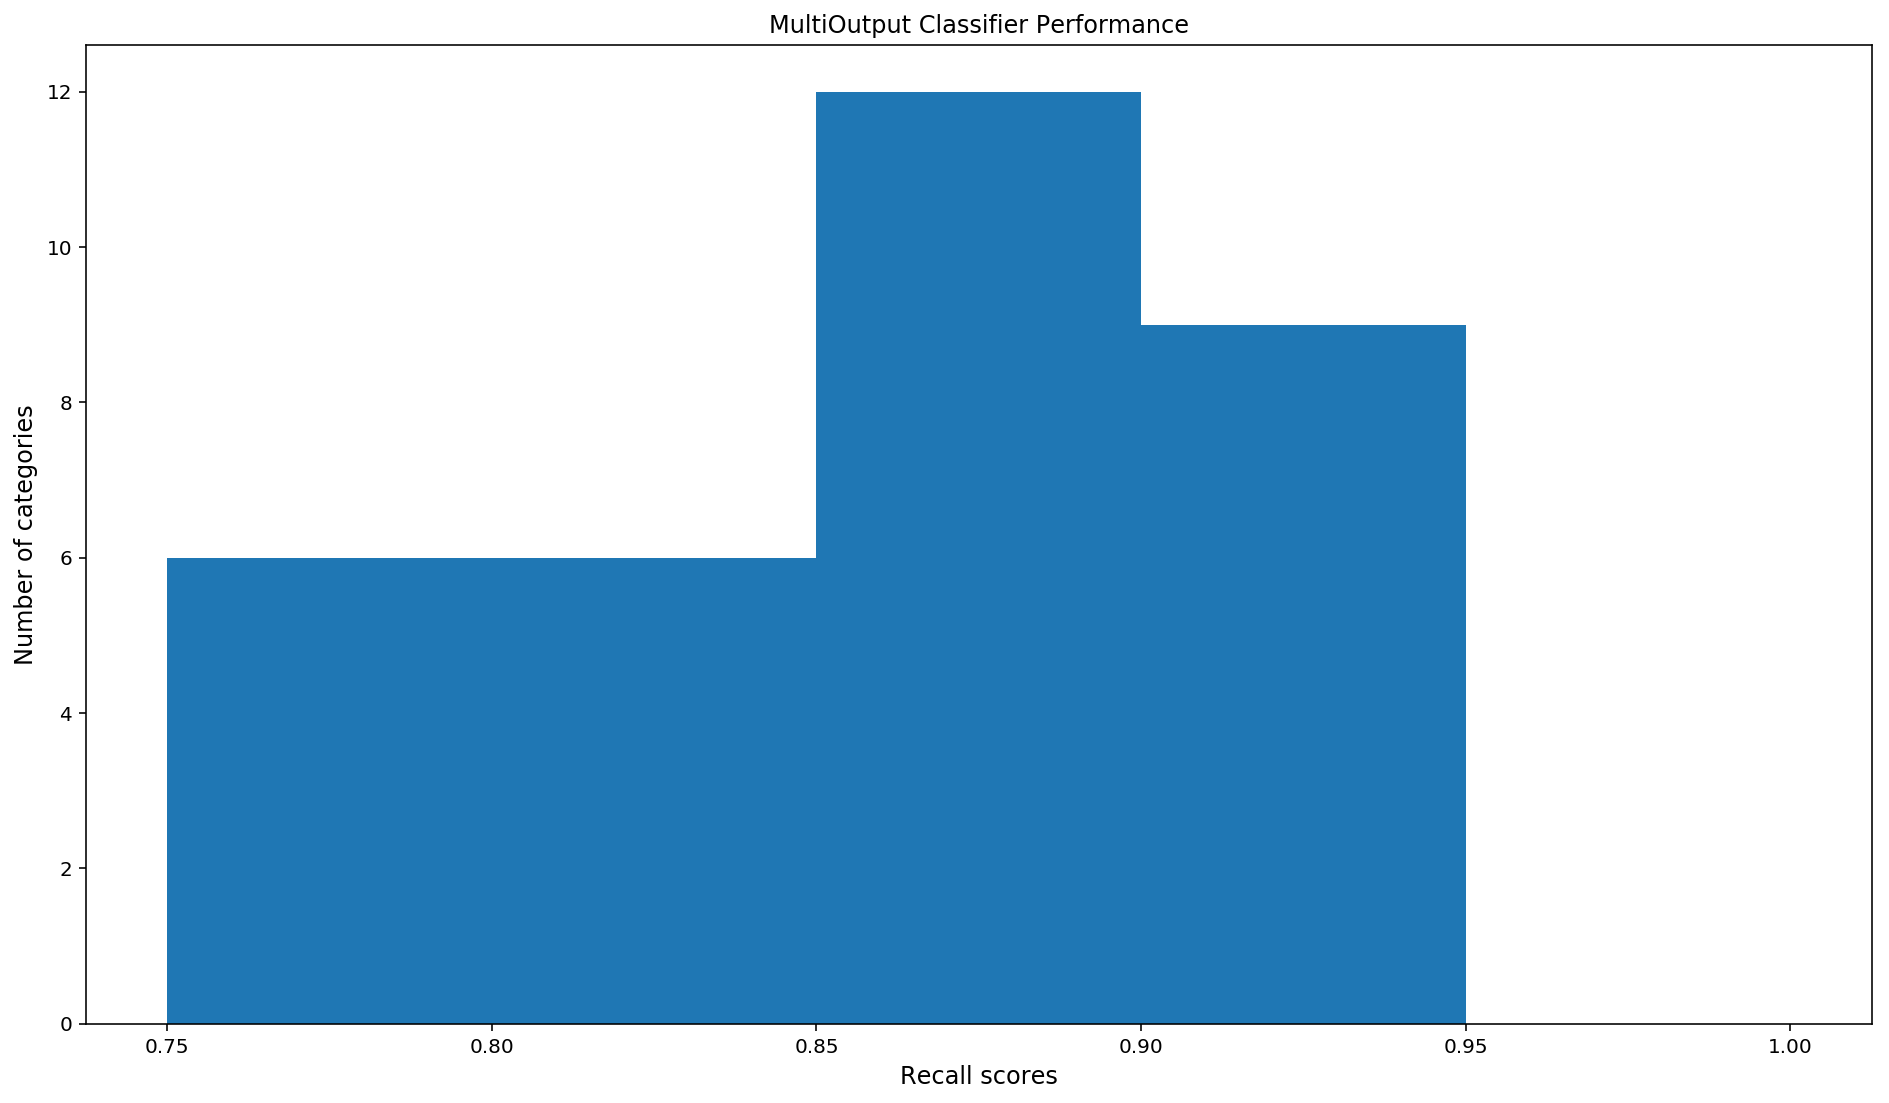

In [281]:
# Visualize distribution of recall scores for best fit classifier
fig, ax = plt.subplots(figsize = (16,9))
plt.hist(recall_scores, bins=[0.75,0.8,0.85,0.9,0.95,1.0])
ax.set_xlabel('Recall scores',fontsize=12)
ax.set_ylabel('Number of categories',fontsize=12)
ax.set_title('MultiOutput Classifier Performance')
plt.show()

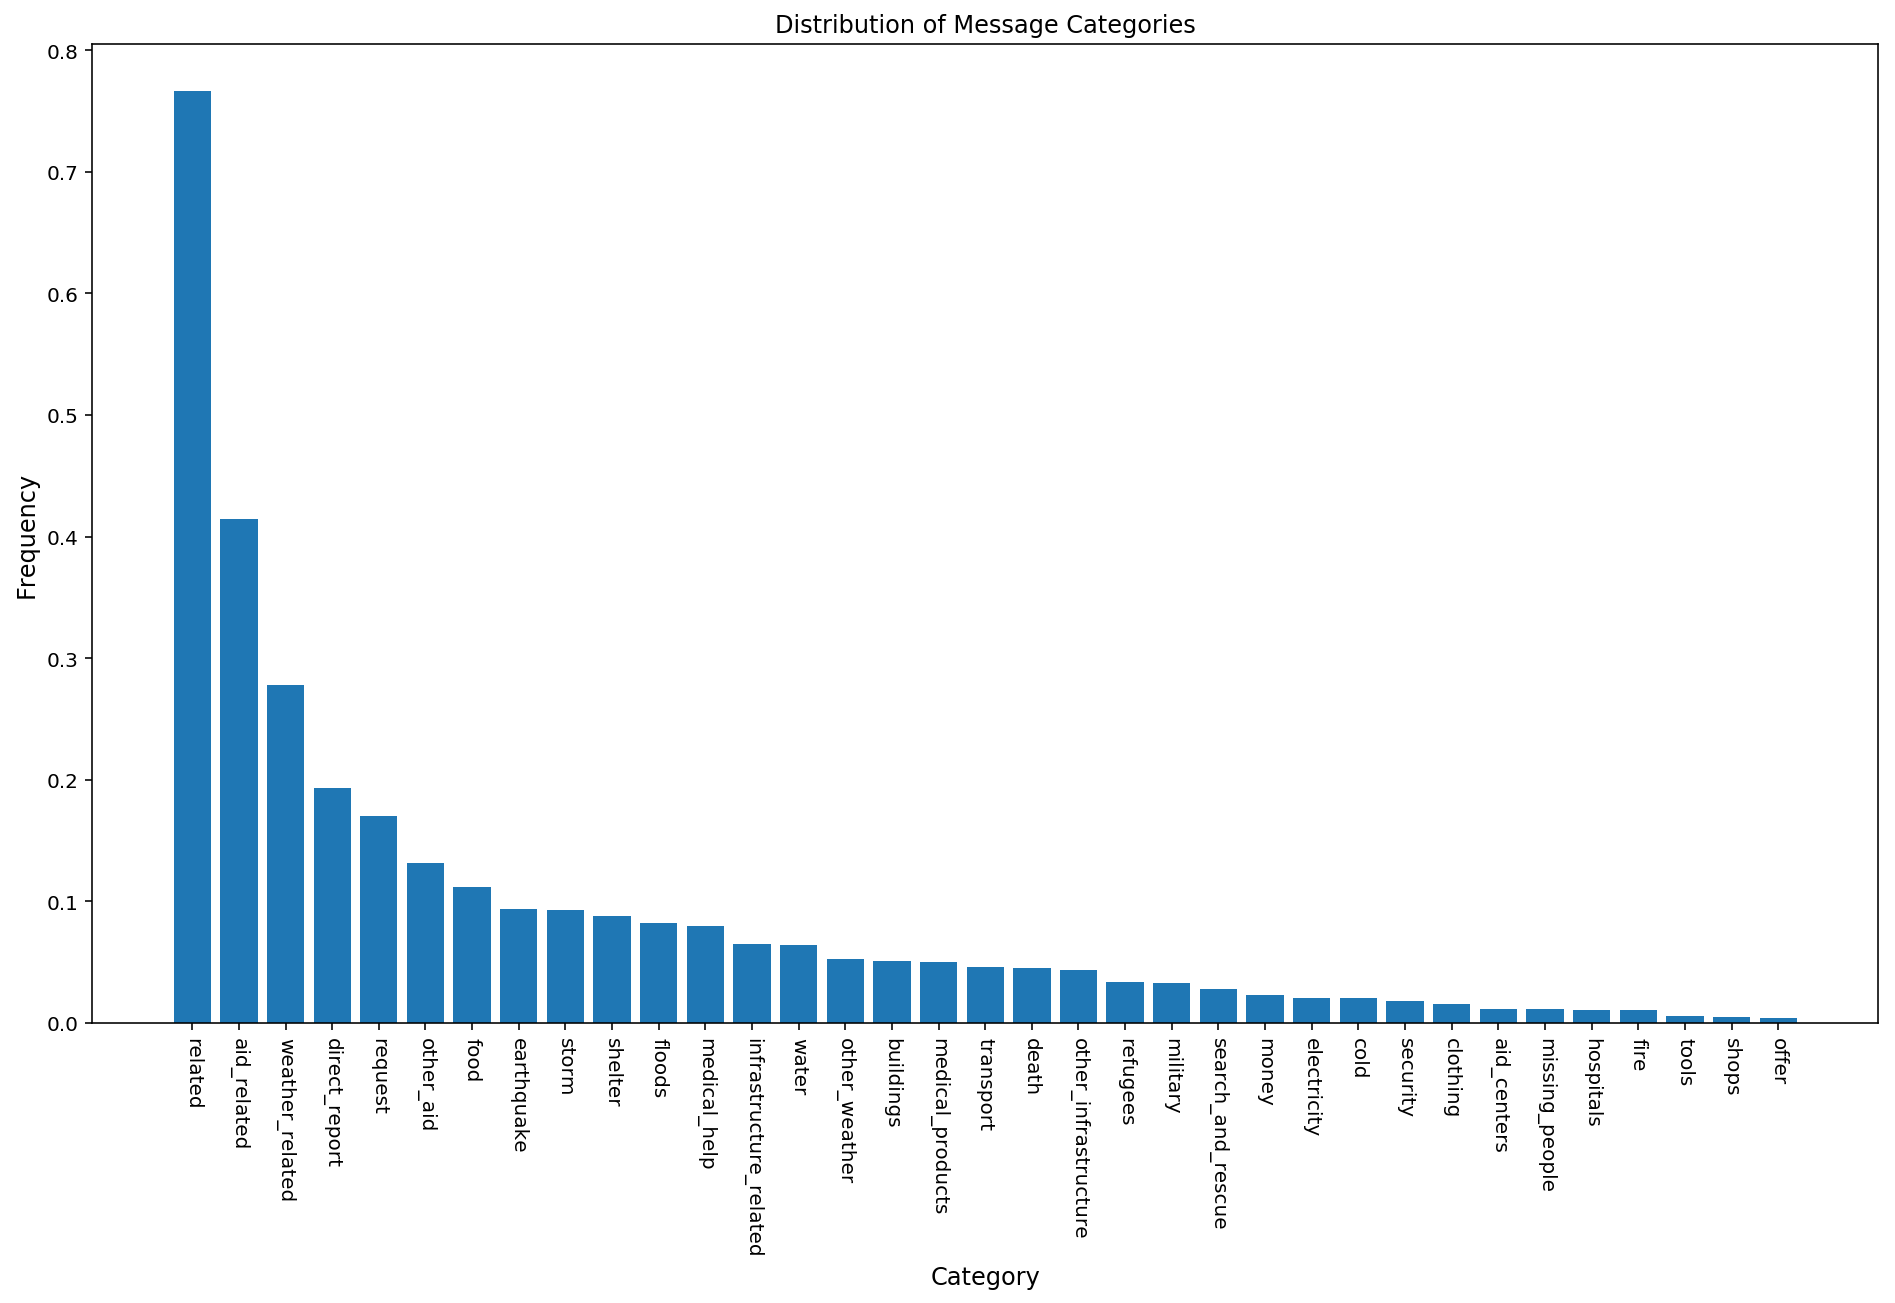

In [300]:
# Visualize distribution of message category frequencies for Web App
category_freqs = df.drop(columns='child_alone').iloc[:,4:].mean(axis=0).sort_values(ascending=False)
category_names = category_freqs.index
fig, ax = plt.subplots(figsize=(16,9))
plt.bar(category_names,category_freqs)
ax.set_xticklabels(category_names,rotation=-90,ha='center')
ax.set_xlabel('Category',fontsize=12)
ax.set_ylabel('Frequency',fontsize=12)
ax.set_title('Distribution of Message Categories')

plt.show()

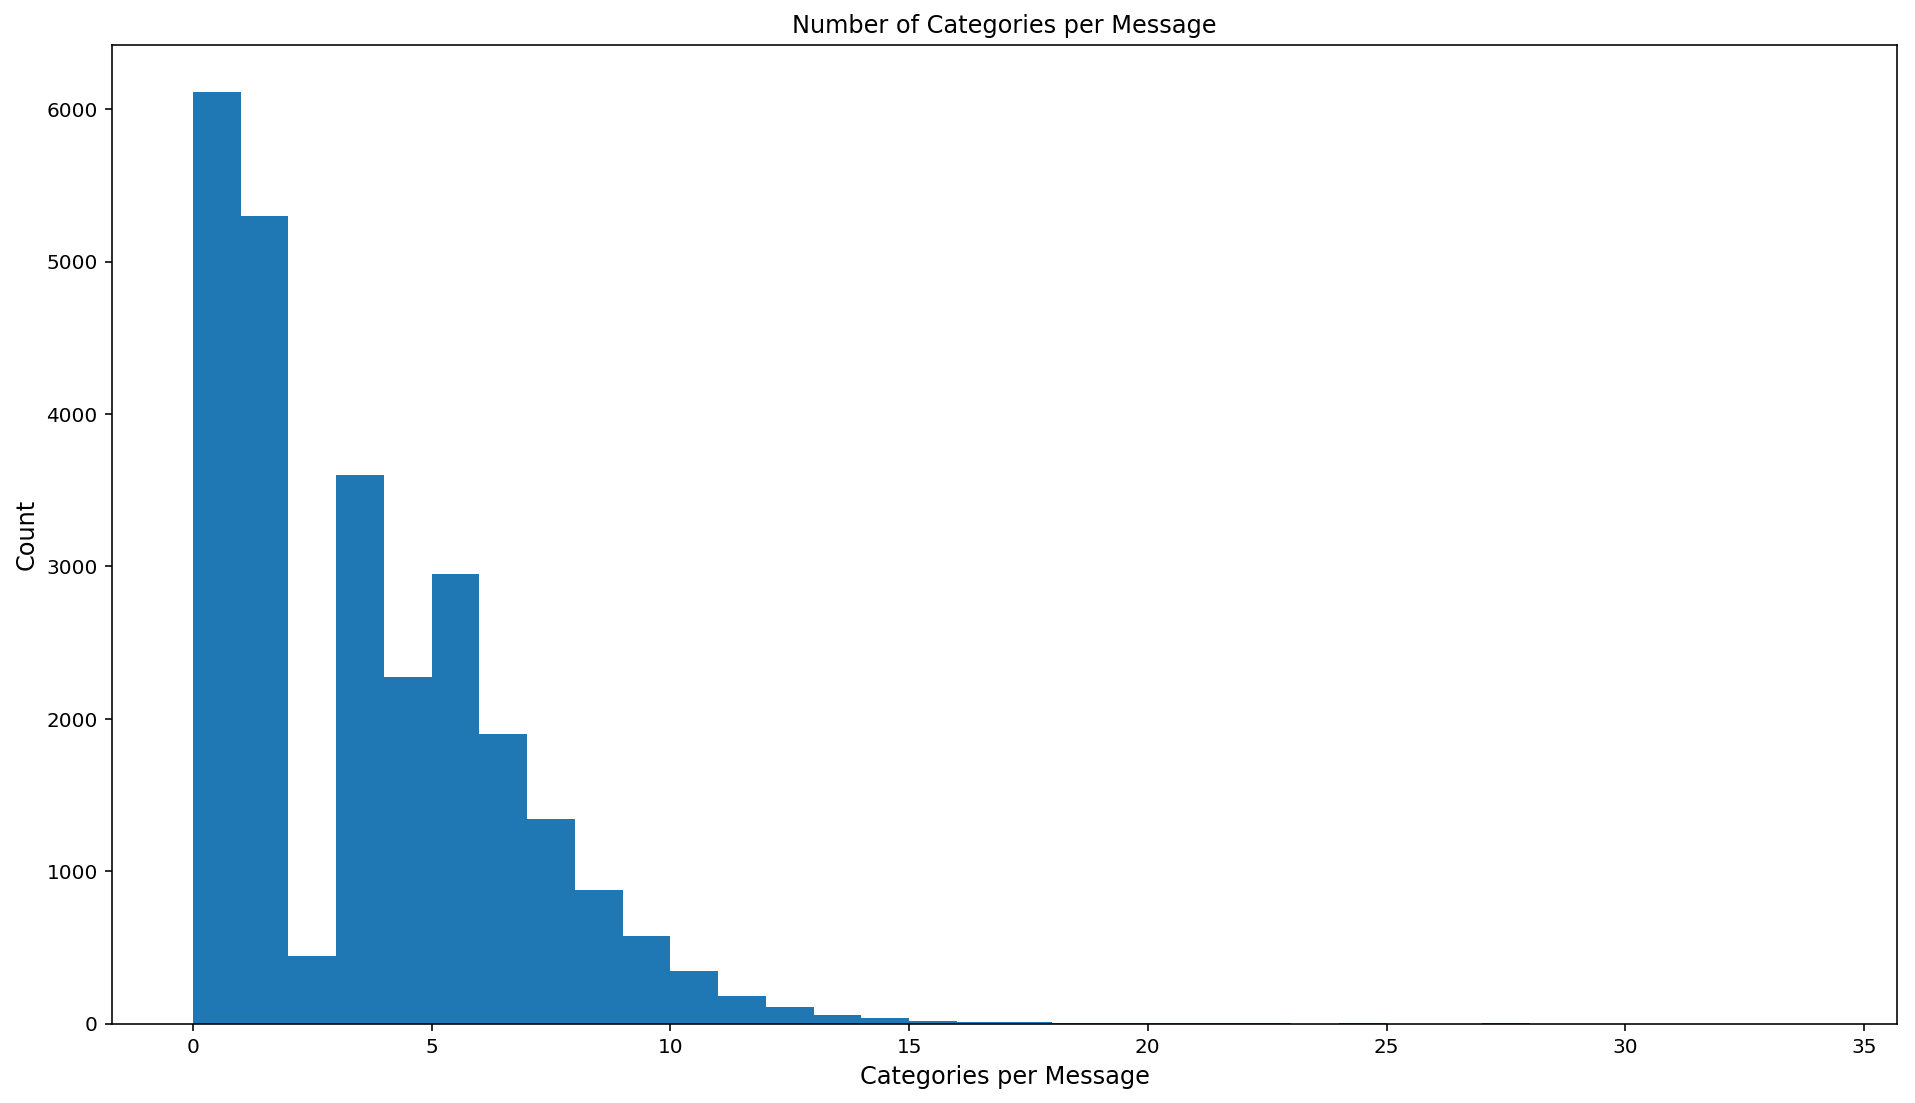

In [312]:
# Visualize number of categories per message for Web App
cats_per_message = df.iloc[:,4:].sum(axis=1).tolist()
fig, ax = plt.subplots(figsize=(16,9))
plt.hist(cats_per_message,bins=range(0,35))
ax.set_xlabel('Categories per Message',fontsize=12)
ax.set_ylabel('Count',fontsize=12)
ax.set_title('Number of Categories per Message')
plt.show()